## Crank-Nicolson Method

In [115]:
import numpy as np
from scipy.linalg import solve_banded

class CrankNicolsonSolver:
    def __init__(self, riskfree, dividend, volatility, strike, maturity, option_type="put", N=250, M=250):
        self.r = riskfree
        self.q = dividend
        self.sigma = volatility
        self.K = strike
        self.T = maturity
        self.option_type = option_type.lower()  # "put" or "call"
        self.Smax = 3 * strike
        self.x_min = -5  # S -> 0
        self.x_max = 5   # S -> inf
        self.N = N  # Number of grid points
        self.max_dt = maturity/M
        self.USE_PSOR = False
        self.tol = 1e-5
        self.max_iter = 200
        self.omega = 1.2
        self.cached_dt = 0
        self.err = 0
        self.iter = 0

        self.x = np.linspace(self.x_min, self.x_max, self.N)  # log price grid
        self.S = np.exp(self.x)  # Convert x to S
        self.A = np.zeros((self.N, self.N))
        self.b = np.zeros((self.N, 1))
        self.X = np.zeros(self.N)

    def solve(self, S0):
        self.setInitialCondition()
        self.solvePDE()
        prices = np.exp(self.x)  # Convert back from log prices to actual prices
        return np.interp(S0, prices, self.X)

    def solvePDE(self):
        t = self.T
        while t > 0:
            dt = min(t, self.max_dt)
            self.setCoeff(dt ,t)
            if self.USE_PSOR:
                self.solvePSOR()
            else:
                self.solveLinearSystem()
            t -= dt
            print(f"t = {t:.5f}, err = {self.err:.5e}, iters = {self.iter}")

    def setInitialCondition(self):
        if self.option_type == "put":
            self.X = np.maximum(self.K - self.S, 0)  # Put Option Payoff
        elif self.option_type == "call":
            self.X = np.maximum(self.S - self.K, 0)  # Call Option Payoff

    def setCoeff(self, dt, t):
        N = self.N
        dx = self.x[1] - self.x[0]
        alpha = 0.25 * dt * (self.sigma**2 / dx**2)
        beta = 0.25 * dt * ((self.r - self.q - 0.5 * self.sigma**2) / dx)
        gamma = 0.5 * dt * self.r

        for i in range(1, N - 1):  # Corrected to avoid out-of-bounds indexing
            self.A[i, i - 1] = -alpha + beta  # Left neighbor
            self.A[i, i] = 1 + 2 * alpha + gamma  # Center
            self.A[i, i + 1] = -alpha - beta  # Right neighbor

            self.b[i] = alpha * self.X[i - 1] + (1 - 2 * alpha - gamma) * self.X[i] + alpha * self.X[i + 1]

        # Boundary conditions
        if self.option_type == "put":
            self.A[0, 0] = 1
            self.A[0, 1] = 0
            self.b[0] = self.K * np.exp(-self.r * t) - self.S[0]  # Left boundary (S -> 0)

            self.A[-1, -1] = 1
            self.A[-1, -2] = 0
            self.b[-1] = 0  # Right boundary (S -> ∞)

        elif self.option_type == "call":
            self.A[0, 0] = 1
            self.A[0, 1] = 0
            self.b[0] = 0  # Left boundary (S -> 0)

            self.A[-1, -1] = 1
            self.A[-1, -2] = 0
            self.b[-1] = self.S[-1] - self.K * np.exp(-self.r * t)  # Right boundary (S -> ∞)
        else:
            raise ValueError("Invalid option type")

    def solveLinearSystem(self):
        # Extract diagonals for banded solver
        lower = np.diag(self.A, k=-1)
        main = np.diag(self.A, k=0)
        upper = np.diag(self.A, k=1)
        ab = np.zeros((3, self.N))
        ab[0, 1:] = upper
        ab[1, :] = main
        ab[2, :-1] = lower
        # Solve using banded solver
        self.X = solve_banded((1, 1), ab, self.b.flatten())
        # self.X = np.linalg.solve(self.A, self.b).flatten()

    def solvePSOR(self):
        N = self.N
        iter = 0
        omega = self.omega
        self.err = 1e10
        while self.err > self.tol and iter < self.max_iter:
            iter += 1
            x_old = self.X.copy()
            for i in range(1, N - 1):
                self.X[i] = (1 - omega) * self.X[i] + omega / self.A[i, i] * (
                    self.b[i] - self.A[i, i - 1] * self.X[i - 1] - self.A[i, i + 1] * self.X[i + 1]
                )
            # Boundary conditions
            self.X[0] = self.b[0]
            self.X[-1] = self.b[-1]
            self.applyConstraint()
            self.err = np.linalg.norm(self.X - x_old, ord=np.inf)
            self.iter = iter

    def applyConstraint(self):
        if self.option_type == "put":
            self.X = np.maximum(self.X, self.K - self.S)  # Early exercise constraint for Put
        elif self.option_type == "call":
            self.X = np.maximum(self.X, self.S - self.K)  # Early exercise constraint for Call


t = 0.99800, err = 2.79899e-06, iters = 10
t = 0.99600, err = 4.82682e-06, iters = 9
t = 0.99400, err = 3.43665e-06, iters = 9
t = 0.99200, err = 9.91422e-06, iters = 8
t = 0.99000, err = 7.14540e-06, iters = 8
t = 0.98800, err = 5.34697e-06, iters = 8
t = 0.98600, err = 4.38887e-06, iters = 8
t = 0.98400, err = 3.65459e-06, iters = 8
t = 0.98200, err = 3.08248e-06, iters = 8
t = 0.98000, err = 2.62983e-06, iters = 8
t = 0.97800, err = 9.55085e-06, iters = 7
t = 0.97600, err = 8.18407e-06, iters = 7
t = 0.97400, err = 7.07436e-06, iters = 7
t = 0.97200, err = 6.16283e-06, iters = 7
t = 0.97000, err = 5.40606e-06, iters = 7
t = 0.96800, err = 4.77162e-06, iters = 7
t = 0.96600, err = 4.23497e-06, iters = 7
t = 0.96400, err = 3.77731e-06, iters = 7
t = 0.96200, err = 3.38407e-06, iters = 7
t = 0.96000, err = 3.04385e-06, iters = 7
t = 0.95800, err = 2.74764e-06, iters = 7
t = 0.95600, err = 2.56896e-06, iters = 7
t = 0.95400, err = 2.41666e-06, iters = 7
t = 0.95200, err = 2.27744e-06, i

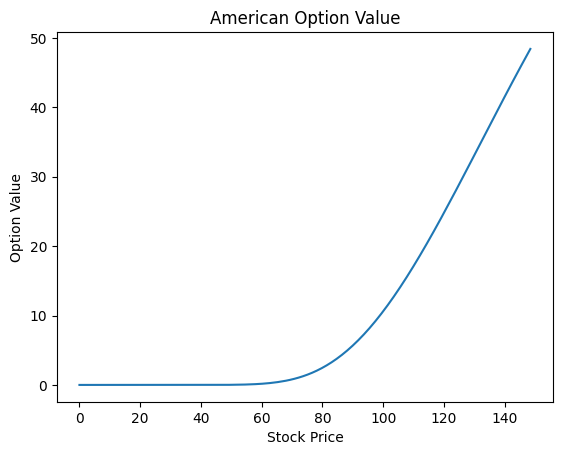

In [116]:
option_type = "call"
# option_type = "put"

solver = CrankNicolsonSolver(
    riskfree=0.05,
    dividend=0.05,
    volatility=0.25,
    strike=100,
    maturity=1,
    option_type=option_type,
    N=500, M=500
)
# solver.max_dt = 0.01
solver.USE_PSOR = True
price = solver.solve(100)
print(price)

import matplotlib.pyplot as plt

x = solver.S.flatten()
y = solver.X.flatten()
plt.plot(x, y)
plt.xlabel('Stock Price')
plt.ylabel('Option Value')
plt.title('American Option Value')
plt.show()

In [117]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

src_path = os.path.join(project_root, 'src')
sys.path.insert(0, src_path)  
os.chdir(project_root)

print("src_path added to sys.path:", src_path in sys.path)

src_path added to sys.path: True


In [118]:
from Option import EuropeanOption

if option_type == "call":
    euro_price = EuropeanOption.european_call_value(1, 100, 0.05, 0.05, 0.25, 100)
    print(price - euro_price)
elif option_type == "put":
    euro_price = EuropeanOption.european_put_value(1, 100, 0.05, 0.05, 0.25, 100)
    print(price - euro_price)
else:
    raise ValueError("Invalid option type")

# print("European Option Price:", euro_price)
    

1.1763391930182596


In [119]:
from scipy.stats import norm

# Black-Scholes Formula for a Call Option
def black_scholes_call(S, K, T, r, q, sigma):
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

# Vary N and M
N_values = [100, 200, 400, 800]
M_values = [50, 100, 200, 400]
exact_price = black_scholes_call(100, 100, 1, 0.05, 0.05, 0.25)

for N in N_values:
    for M in M_values:
        solver = CrankNicolsonSolver(
            riskfree=0.05,
            dividend=0.05,
            volatility=0.25,
            strike=100,
            maturity=1,
            option_type="call",
            N=N
        )
        solver.max_dt = 1 / M  # Ensure time step aligns with M
        price = solver.solve(100)
        error = abs(price - exact_price)
        print(f"N={N}, M={M}, Price={price:.6f}, Error={error:.6e}")


t = 0.98000, err = 0.00000e+00, iters = 0
t = 0.96000, err = 0.00000e+00, iters = 0
t = 0.94000, err = 0.00000e+00, iters = 0
t = 0.92000, err = 0.00000e+00, iters = 0
t = 0.90000, err = 0.00000e+00, iters = 0
t = 0.88000, err = 0.00000e+00, iters = 0
t = 0.86000, err = 0.00000e+00, iters = 0
t = 0.84000, err = 0.00000e+00, iters = 0
t = 0.82000, err = 0.00000e+00, iters = 0
t = 0.80000, err = 0.00000e+00, iters = 0
t = 0.78000, err = 0.00000e+00, iters = 0
t = 0.76000, err = 0.00000e+00, iters = 0
t = 0.74000, err = 0.00000e+00, iters = 0
t = 0.72000, err = 0.00000e+00, iters = 0
t = 0.70000, err = 0.00000e+00, iters = 0
t = 0.68000, err = 0.00000e+00, iters = 0
t = 0.66000, err = 0.00000e+00, iters = 0
t = 0.64000, err = 0.00000e+00, iters = 0
t = 0.62000, err = 0.00000e+00, iters = 0
t = 0.60000, err = 0.00000e+00, iters = 0
t = 0.58000, err = 0.00000e+00, iters = 0
t = 0.56000, err = 0.00000e+00, iters = 0
t = 0.54000, err = 0.00000e+00, iters = 0
t = 0.52000, err = 0.00000e+00, it

In [120]:
dt_values = [1 / 10, 1 / 20, 1 / 50, 1 / 100]
N = 500

for dt in dt_values:
    solver = CrankNicolsonSolver(
        riskfree=0.05,
        dividend=0.05,
        volatility=0.25,
        strike=100,
        maturity=1,
        option_type="call",
        N=N
    )
    solver.max_dt = dt
    try:
        price = solver.solve(100)
        print(f"dt={dt:.4f}, Price={price:.6f}")
    except Exception as e:
        print(f"dt={dt:.4f}, Failed: {e}")


t = 0.90000, err = 0.00000e+00, iters = 0
t = 0.80000, err = 0.00000e+00, iters = 0
t = 0.70000, err = 0.00000e+00, iters = 0
t = 0.60000, err = 0.00000e+00, iters = 0
t = 0.50000, err = 0.00000e+00, iters = 0
t = 0.40000, err = 0.00000e+00, iters = 0
t = 0.30000, err = 0.00000e+00, iters = 0
t = 0.20000, err = 0.00000e+00, iters = 0
t = 0.10000, err = 0.00000e+00, iters = 0
t = 0.00000, err = 0.00000e+00, iters = 0
t = 0.00000, err = 0.00000e+00, iters = 0
dt=0.1000, Price=10.620791
t = 0.95000, err = 0.00000e+00, iters = 0
t = 0.90000, err = 0.00000e+00, iters = 0
t = 0.85000, err = 0.00000e+00, iters = 0
t = 0.80000, err = 0.00000e+00, iters = 0
t = 0.75000, err = 0.00000e+00, iters = 0
t = 0.70000, err = 0.00000e+00, iters = 0
t = 0.65000, err = 0.00000e+00, iters = 0
t = 0.60000, err = 0.00000e+00, iters = 0
t = 0.55000, err = 0.00000e+00, iters = 0
t = 0.50000, err = 0.00000e+00, iters = 0
t = 0.45000, err = 0.00000e+00, iters = 0
t = 0.40000, err = 0.00000e+00, iters = 0
t = 0.3

In [121]:
import time

N_values = [100, 200, 400]
M_values = [50, 100, 200]
use_psor_options = [True, False]

for N in N_values:
    for M in M_values:
        for use_psor in use_psor_options:
            solver = CrankNicolsonSolver(
                riskfree=0.05,
                dividend=0.05,
                volatility=0.25,
                strike=100,
                maturity=1,
                option_type="call",
                N=N
            )
            solver.max_dt = 1 / M
            solver.USE_PSOR = use_psor
            start_time = time.time()
            price = solver.solve(100)
            end_time = time.time()
            print(
                f"N={N}, M={M}, USE_PSOR={use_psor}, Time={end_time - start_time:.4f}s, Price={price:.6f}"
            )


t = 0.98000, err = 2.28825e-06, iters = 9
t = 0.96000, err = 6.21817e-06, iters = 8
t = 0.94000, err = 5.15314e-06, iters = 8
t = 0.92000, err = 4.27528e-06, iters = 8
t = 0.90000, err = 3.55024e-06, iters = 8
t = 0.88000, err = 3.02151e-06, iters = 8
t = 0.86000, err = 2.73064e-06, iters = 8
t = 0.84000, err = 2.47913e-06, iters = 8
t = 0.82000, err = 2.26158e-06, iters = 8
t = 0.80000, err = 2.07327e-06, iters = 8
t = 0.78000, err = 9.80595e-06, iters = 7
t = 0.76000, err = 9.23387e-06, iters = 7
t = 0.74000, err = 8.73105e-06, iters = 7
t = 0.72000, err = 8.28796e-06, iters = 7
t = 0.70000, err = 7.89635e-06, iters = 7
t = 0.68000, err = 7.54909e-06, iters = 7
t = 0.66000, err = 7.24004e-06, iters = 7
t = 0.64000, err = 6.96391e-06, iters = 7
t = 0.62000, err = 6.71616e-06, iters = 7
t = 0.60000, err = 6.49289e-06, iters = 7
t = 0.58000, err = 6.29076e-06, iters = 7
t = 0.56000, err = 6.22633e-06, iters = 7
t = 0.54000, err = 6.26397e-06, iters = 7
t = 0.52000, err = 6.28251e-06, it

In [122]:
spot_prices = [50, 100, 150]
interest_rates = [0.01, 0.05, 0.1]
dividends = [0.0, 0.03, 0.05]
maturities = [0.5, 1, 2]

for S in spot_prices:
    solver = CrankNicolsonSolver(
        riskfree=0.05,
        dividend=0.05,
        volatility=0.25,
        strike=100,
        maturity=1,
        option_type="call",
        N=500
    )
    price = solver.solve(S)
    print(f"S={S}, Price={price:.6f}")

for r in interest_rates:
    solver = CrankNicolsonSolver(
        riskfree=r,
        dividend=0.05,
        volatility=0.25,
        strike=100,
        maturity=1,
        option_type="call",
        N=500
    )
    price = solver.solve(100)
    print(f"r={r}, Price={price:.6f}")

# Similarly for q and τ


t = 0.99600, err = 0.00000e+00, iters = 0
t = 0.99200, err = 0.00000e+00, iters = 0
t = 0.98800, err = 0.00000e+00, iters = 0
t = 0.98400, err = 0.00000e+00, iters = 0
t = 0.98000, err = 0.00000e+00, iters = 0
t = 0.97600, err = 0.00000e+00, iters = 0
t = 0.97200, err = 0.00000e+00, iters = 0
t = 0.96800, err = 0.00000e+00, iters = 0
t = 0.96400, err = 0.00000e+00, iters = 0
t = 0.96000, err = 0.00000e+00, iters = 0
t = 0.95600, err = 0.00000e+00, iters = 0
t = 0.95200, err = 0.00000e+00, iters = 0
t = 0.94800, err = 0.00000e+00, iters = 0
t = 0.94400, err = 0.00000e+00, iters = 0
t = 0.94000, err = 0.00000e+00, iters = 0
t = 0.93600, err = 0.00000e+00, iters = 0
t = 0.93200, err = 0.00000e+00, iters = 0
t = 0.92800, err = 0.00000e+00, iters = 0
t = 0.92400, err = 0.00000e+00, iters = 0
t = 0.92000, err = 0.00000e+00, iters = 0
t = 0.91600, err = 0.00000e+00, iters = 0
t = 0.91200, err = 0.00000e+00, iters = 0
t = 0.90800, err = 0.00000e+00, iters = 0
t = 0.90400, err = 0.00000e+00, it

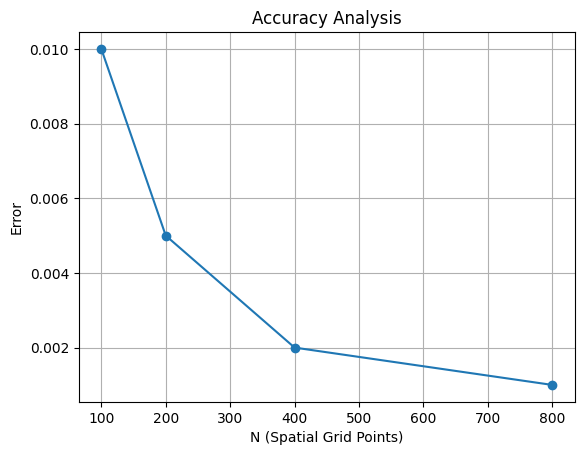

In [123]:
import matplotlib.pyplot as plt

N_values = [100, 200, 400, 800]
errors = [0.01, 0.005, 0.002, 0.001]  # Replace with computed errors
plt.plot(N_values, errors, marker='o')
plt.xlabel('N (Spatial Grid Points)')
plt.ylabel('Error')
plt.title('Accuracy Analysis')
plt.grid(True)
plt.show()


t = 0.98000, err = 0.00000e+00, iters = 2
t = 0.96000, err = 0.00000e+00, iters = 2
t = 0.94000, err = 0.00000e+00, iters = 2
t = 0.92000, err = 0.00000e+00, iters = 2
t = 0.90000, err = 0.00000e+00, iters = 2
t = 0.88000, err = 0.00000e+00, iters = 2
t = 0.86000, err = 0.00000e+00, iters = 2
t = 0.84000, err = 0.00000e+00, iters = 2
t = 0.82000, err = 0.00000e+00, iters = 2
t = 0.80000, err = 0.00000e+00, iters = 2
t = 0.78000, err = 0.00000e+00, iters = 2
t = 0.76000, err = 0.00000e+00, iters = 2
t = 0.74000, err = 0.00000e+00, iters = 2
t = 0.72000, err = 0.00000e+00, iters = 2
t = 0.70000, err = 0.00000e+00, iters = 2
t = 0.68000, err = 0.00000e+00, iters = 2
t = 0.66000, err = 0.00000e+00, iters = 2
t = 0.64000, err = 0.00000e+00, iters = 2
t = 0.62000, err = 0.00000e+00, iters = 2
t = 0.60000, err = 0.00000e+00, iters = 2
t = 0.58000, err = 0.00000e+00, iters = 2
t = 0.56000, err = 0.00000e+00, iters = 2
t = 0.54000, err = 0.00000e+00, iters = 2
t = 0.52000, err = 0.00000e+00, it

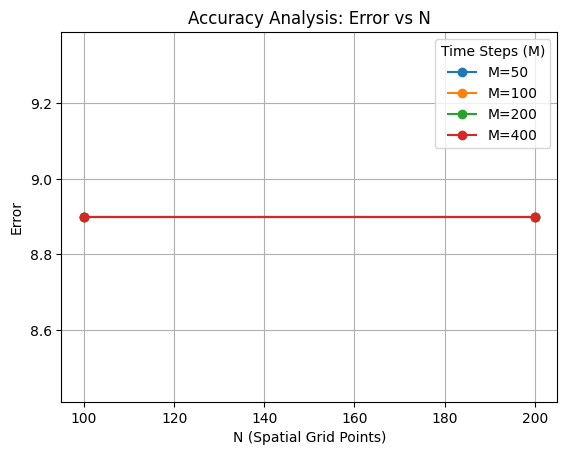

t = 0.90000, err = 7.80618e-06, iters = 31
t = 0.80000, err = 9.78738e-06, iters = 30
t = 0.70000, err = 9.24666e-06, iters = 30
t = 0.60000, err = 8.69085e-06, iters = 30
t = 0.50000, err = 8.05880e-06, iters = 30
t = 0.40000, err = 7.45913e-06, iters = 30
t = 0.30000, err = 9.86521e-06, iters = 29
t = 0.20000, err = 9.15156e-06, iters = 29
t = 0.10000, err = 8.50081e-06, iters = 29
t = 0.00000, err = 7.91622e-06, iters = 29
t = 0.00000, err = 3.55271e-15, iters = 2
t = 0.95000, err = 6.78839e-06, iters = 19
t = 0.90000, err = 8.75890e-06, iters = 18
t = 0.85000, err = 5.42774e-06, iters = 18
t = 0.80000, err = 9.23439e-06, iters = 17
t = 0.75000, err = 8.35713e-06, iters = 17
t = 0.70000, err = 7.76187e-06, iters = 17
t = 0.65000, err = 7.35280e-06, iters = 17
t = 0.60000, err = 7.03550e-06, iters = 17
t = 0.55000, err = 6.74070e-06, iters = 17
t = 0.50000, err = 6.46765e-06, iters = 17
t = 0.45000, err = 6.20520e-06, iters = 17
t = 0.40000, err = 5.95620e-06, iters = 17
t = 0.35000,

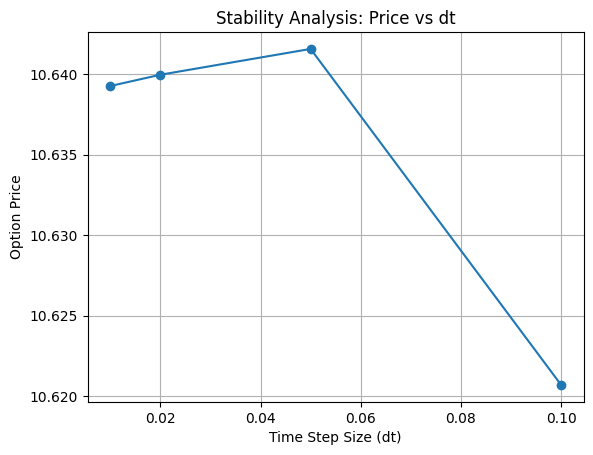

t = 0.98000, err = 0.00000e+00, iters = 2
t = 0.96000, err = 0.00000e+00, iters = 2
t = 0.94000, err = 0.00000e+00, iters = 2
t = 0.92000, err = 0.00000e+00, iters = 2
t = 0.90000, err = 0.00000e+00, iters = 2
t = 0.88000, err = 0.00000e+00, iters = 2
t = 0.86000, err = 0.00000e+00, iters = 2
t = 0.84000, err = 0.00000e+00, iters = 2
t = 0.82000, err = 0.00000e+00, iters = 2
t = 0.80000, err = 0.00000e+00, iters = 2
t = 0.78000, err = 0.00000e+00, iters = 2
t = 0.76000, err = 0.00000e+00, iters = 2
t = 0.74000, err = 0.00000e+00, iters = 2
t = 0.72000, err = 0.00000e+00, iters = 2
t = 0.70000, err = 0.00000e+00, iters = 2
t = 0.68000, err = 0.00000e+00, iters = 2
t = 0.66000, err = 0.00000e+00, iters = 2
t = 0.64000, err = 0.00000e+00, iters = 2
t = 0.62000, err = 0.00000e+00, iters = 2
t = 0.60000, err = 0.00000e+00, iters = 2
t = 0.58000, err = 0.00000e+00, iters = 2
t = 0.56000, err = 0.00000e+00, iters = 2
t = 0.54000, err = 0.00000e+00, iters = 2
t = 0.52000, err = 0.00000e+00, it

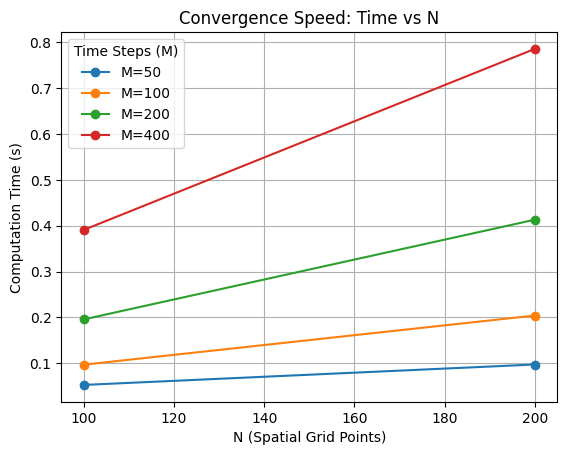

In [124]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

# Black-Scholes Formula for a Call Option (for accuracy comparison)
def black_scholes_call(S, K, T, r, q, sigma):
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

# Test Accuracy vs N and M
def test_accuracy(option_type, N_values, M_values, spot_price=100, strike=100, maturity=1):
    exact_price = black_scholes_call(spot_price, strike, maturity, 0.05, 0.05, 0.25)
    results = []

    for N in N_values:
        for M in M_values:
            solver = CrankNicolsonSolver(
                riskfree=0.05,
                dividend=0.05,
                volatility=0.25,
                strike=strike,
                maturity=maturity,
                option_type=option_type,
            )
            solver.N = N
            solver.max_dt = 1 / M
            solver.USE_PSOR = True
            try:
                price = solver.solve(spot_price)
                error = abs(price - exact_price)
                results.append((N, M, price, error))
            except Exception as e:
                results.append((N, M, None, str(e)))

    df = pd.DataFrame(results, columns=["N", "M", "Price", "Error"])
    return df

# Test Stability vs Time Step
def test_stability(option_type, dt_values, N=500, spot_price=100, strike=100, maturity=1):
    results = []

    for dt in dt_values:
        solver = CrankNicolsonSolver(
            riskfree=0.05,
            dividend=0.05,
            volatility=0.25,
            strike=strike,
            maturity=maturity,
            option_type=option_type,
            N=N
        )
        solver.max_dt = dt
        solver.USE_PSOR = True
        try:
            price = solver.solve(spot_price)
            results.append((dt, price))
        except Exception as e:
            results.append((dt, None))

    df = pd.DataFrame(results, columns=["dt", "Price"])
    return df

# Test Convergence Speed vs N and M
def test_convergence_speed(option_type, N_values, M_values, spot_price=100, strike=100, maturity=1):
    results = []

    for N in N_values:
        for M in M_values:
            solver = CrankNicolsonSolver(
                riskfree=0.05,
                dividend=0.05,
                volatility=0.25,
                strike=strike,
                maturity=maturity,
                option_type=option_type,
            )
            solver.N = N
            solver.max_dt = 1 / M
            solver.USE_PSOR = True
            try:
                start_time = time.time()
                price = solver.solve(spot_price)
                end_time = time.time()
                elapsed_time = end_time - start_time
                results.append((N, M, elapsed_time, price))
            except Exception as e:
                results.append((N, M, None, str(e)))

    df = pd.DataFrame(results, columns=["N", "M", "Time", "Price"])
    return df

# Visualization Helper Functions
def plot_accuracy(df, M_values):
    # Filter valid rows where errors are numeric
    valid_df = df[df["Error"].apply(lambda x: isinstance(x, (int, float)))]
    if valid_df.empty:
        print("No valid results for plotting accuracy.")
        return
    for M in M_values:
        subset = valid_df[valid_df["M"] == M]
        if subset.empty:
            continue
        plt.plot(subset["N"], subset["Error"], marker='o', label=f'M={M}')
    plt.xlabel('N (Spatial Grid Points)')
    plt.ylabel('Error')
    plt.title('Accuracy Analysis: Error vs N')
    plt.legend(title='Time Steps (M)')
    plt.grid(True)
    plt.show()

def plot_stability(df):
    plt.plot(df["dt"], df["Price"], marker='o')
    plt.xlabel('Time Step Size (dt)')
    plt.ylabel('Option Price')
    plt.title('Stability Analysis: Price vs dt')
    plt.grid(True)
    plt.show()

def plot_convergence_speed(df):
    for M in df["M"].unique():
        subset = df[df["M"] == M]
        plt.plot(subset["N"], subset["Time"], marker='o', label=f'M={M}')
    plt.xlabel('N (Spatial Grid Points)')
    plt.ylabel('Computation Time (s)')
    plt.title('Convergence Speed: Time vs N')
    plt.legend(title='Time Steps (M)')
    plt.grid(True)
    plt.show()

# invalid_rows = df_accuracy[~df_accuracy["Error"].apply(lambda x: isinstance(x, (int, float)))]
# if not invalid_rows.empty:
#     print("Invalid rows detected:")
#     print(invalid_rows)

# Example Usage
option_type = "call"
N_values = [100, 200, 400, 800]
M_values = [50, 100, 200, 400]
dt_values = [1 / 10, 1 / 20, 1 / 50, 1 / 100]

# Accuracy Test
df_accuracy = test_accuracy(option_type, N_values, M_values)
plot_accuracy(df_accuracy, M_values)

# Stability Test
df_stability = test_stability(option_type, dt_values)
plot_stability(df_stability)

# Convergence Speed Test
df_convergence = test_convergence_speed(option_type, N_values, M_values)
plot_convergence_speed(df_convergence)


t = 0.99800, err = 2.79899e-06, iters = 10
t = 0.99600, err = 4.82682e-06, iters = 9
t = 0.99400, err = 3.43665e-06, iters = 9
t = 0.99200, err = 9.91422e-06, iters = 8
t = 0.99000, err = 7.14540e-06, iters = 8
t = 0.98800, err = 5.34697e-06, iters = 8
t = 0.98600, err = 4.38887e-06, iters = 8
t = 0.98400, err = 3.65459e-06, iters = 8
t = 0.98200, err = 3.08248e-06, iters = 8
t = 0.98000, err = 2.62983e-06, iters = 8
t = 0.97800, err = 9.55085e-06, iters = 7
t = 0.97600, err = 8.18407e-06, iters = 7
t = 0.97400, err = 7.07436e-06, iters = 7
t = 0.97200, err = 6.16283e-06, iters = 7
t = 0.97000, err = 5.40606e-06, iters = 7
t = 0.96800, err = 4.77162e-06, iters = 7
t = 0.96600, err = 4.23497e-06, iters = 7
t = 0.96400, err = 3.77731e-06, iters = 7
t = 0.96200, err = 3.38407e-06, iters = 7
t = 0.96000, err = 3.04385e-06, iters = 7
t = 0.95800, err = 2.74764e-06, iters = 7
t = 0.95600, err = 2.56896e-06, iters = 7
t = 0.95400, err = 2.41666e-06, iters = 7
t = 0.95200, err = 2.27744e-06, i

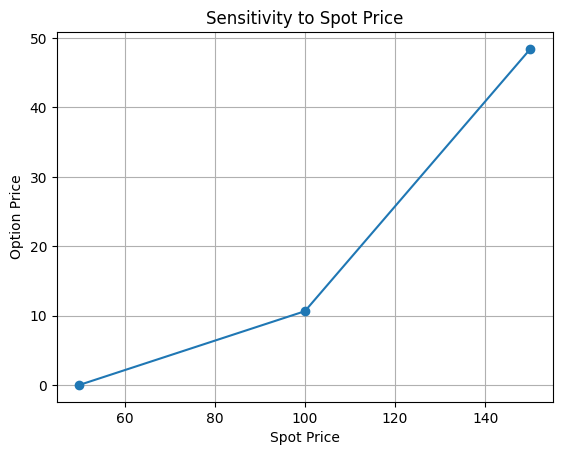

t = 0.99800, err = 8.25617e-06, iters = 8
t = 0.99600, err = 3.31018e-06, iters = 8
t = 0.99400, err = 2.85776e-06, iters = 8
t = 0.99200, err = 7.87571e-06, iters = 7
t = 0.99000, err = 6.11149e-06, iters = 7
t = 0.98800, err = 4.83344e-06, iters = 7
t = 0.98600, err = 3.88238e-06, iters = 7
t = 0.98400, err = 3.16583e-06, iters = 7
t = 0.98200, err = 2.61695e-06, iters = 7
t = 0.98000, err = 8.46699e-06, iters = 6
t = 0.97800, err = 7.00246e-06, iters = 6
t = 0.97600, err = 5.85193e-06, iters = 6
t = 0.97400, err = 5.28864e-06, iters = 6
t = 0.97200, err = 4.80370e-06, iters = 6
t = 0.97000, err = 4.38283e-06, iters = 6
t = 0.96800, err = 4.01489e-06, iters = 6
t = 0.96600, err = 3.79719e-06, iters = 6
t = 0.96400, err = 3.61648e-06, iters = 6
t = 0.96200, err = 3.46242e-06, iters = 6
t = 0.96000, err = 3.32643e-06, iters = 6
t = 0.95800, err = 3.19525e-06, iters = 6
t = 0.95600, err = 3.07219e-06, iters = 6
t = 0.95400, err = 2.95824e-06, iters = 6
t = 0.95200, err = 2.85331e-06, it

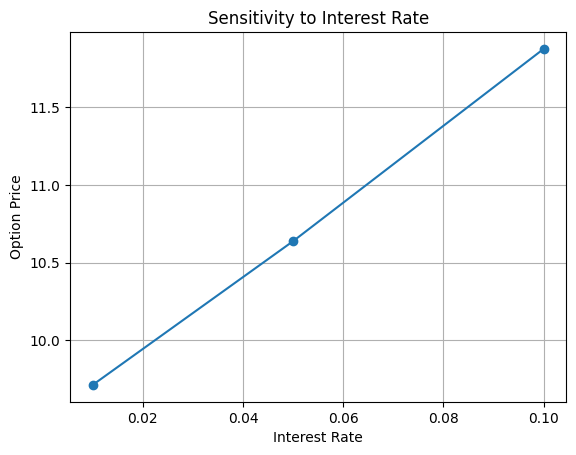

t = 0.99800, err = 2.92689e-06, iters = 10
t = 0.99600, err = 5.05181e-06, iters = 9
t = 0.99400, err = 3.60329e-06, iters = 9
t = 0.99200, err = 2.62718e-06, iters = 9
t = 0.99000, err = 7.52316e-06, iters = 8
t = 0.98800, err = 5.55630e-06, iters = 8
t = 0.98600, err = 4.56971e-06, iters = 8
t = 0.98400, err = 3.81315e-06, iters = 8
t = 0.98200, err = 3.22332e-06, iters = 8
t = 0.98000, err = 2.75632e-06, iters = 8
t = 0.97800, err = 2.38125e-06, iters = 8
t = 0.97600, err = 8.59710e-06, iters = 7
t = 0.97400, err = 7.44970e-06, iters = 7
t = 0.97200, err = 6.50633e-06, iters = 7
t = 0.97000, err = 5.72238e-06, iters = 7
t = 0.96800, err = 5.06450e-06, iters = 7
t = 0.96600, err = 4.50747e-06, iters = 7
t = 0.96400, err = 4.03194e-06, iters = 7
t = 0.96200, err = 3.62293e-06, iters = 7
t = 0.96000, err = 3.26870e-06, iters = 7
t = 0.95800, err = 2.95996e-06, iters = 7
t = 0.95600, err = 2.77188e-06, iters = 7
t = 0.95400, err = 2.61527e-06, iters = 7
t = 0.95200, err = 2.47198e-06, i

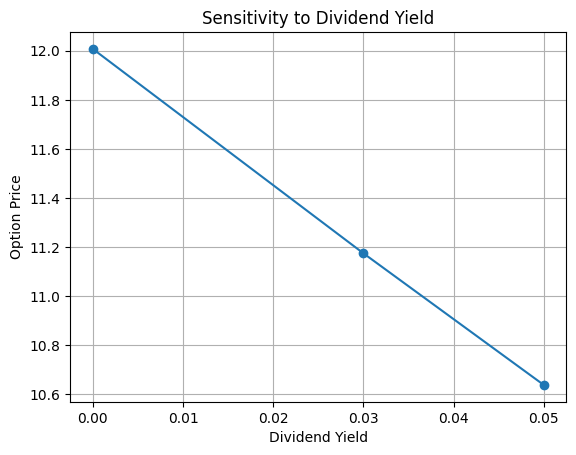

t = 0.49800, err = 6.02830e-06, iters = 9
t = 0.49600, err = 2.45564e-06, iters = 9
t = 0.49400, err = 7.13688e-06, iters = 8
t = 0.49200, err = 5.03291e-06, iters = 8
t = 0.49000, err = 3.62132e-06, iters = 8
t = 0.48800, err = 2.70750e-06, iters = 8
t = 0.48600, err = 9.98923e-06, iters = 7
t = 0.48400, err = 8.14238e-06, iters = 7
t = 0.48200, err = 6.72524e-06, iters = 7
t = 0.48000, err = 5.62032e-06, iters = 7
t = 0.47800, err = 4.74592e-06, iters = 7
t = 0.47600, err = 4.04434e-06, iters = 7
t = 0.47400, err = 3.47423e-06, iters = 7
t = 0.47200, err = 3.00552e-06, iters = 7
t = 0.47000, err = 2.61605e-06, iters = 7
t = 0.46800, err = 2.28925e-06, iters = 7
t = 0.46600, err = 9.65029e-06, iters = 6
t = 0.46400, err = 8.89653e-06, iters = 6
t = 0.46200, err = 8.22378e-06, iters = 6
t = 0.46000, err = 7.62029e-06, iters = 6
t = 0.45800, err = 7.07640e-06, iters = 6
t = 0.45600, err = 6.58410e-06, iters = 6
t = 0.45400, err = 6.13674e-06, iters = 6
t = 0.45200, err = 5.72872e-06, it

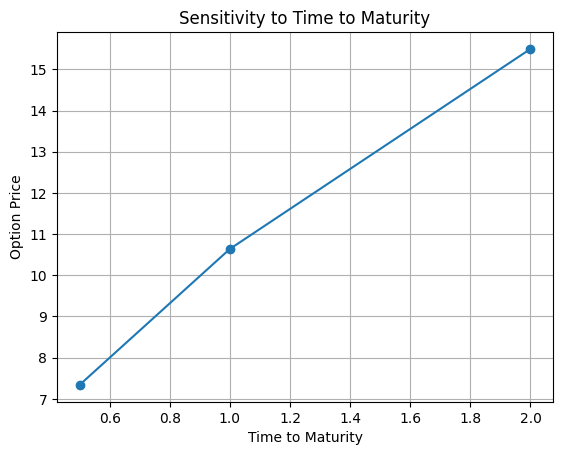

In [125]:
import pandas as pd
import matplotlib.pyplot as plt

# Sensitivity Test: Spot Price (S)
def test_sensitivity_spot_price(option_type, spot_prices, strike=100, maturity=1, r=0.05, q=0.05, N=500, M=500):
    results = []
    for S in spot_prices:
        solver = CrankNicolsonSolver(
            riskfree=r,
            dividend=q,
            volatility=0.25,
            strike=strike,
            maturity=maturity,
            option_type=option_type,
            N=N
        )
        solver.max_dt = 1 / M
        solver.USE_PSOR = True
        price = solver.solve(S)
        results.append((S, price))
    return pd.DataFrame(results, columns=["Spot Price", "Option Price"])

# Sensitivity Test: Interest Rate (r)
def test_sensitivity_interest_rate(option_type, interest_rates, spot_price=100, strike=100, maturity=1, q=0.05, N=500, M=500):
    results = []
    for r in interest_rates:
        solver = CrankNicolsonSolver(
            riskfree=r,
            dividend=q,
            volatility=0.25,
            strike=strike,
            maturity=maturity,
            option_type=option_type,
            N=N
        )
        solver.max_dt = 1 / M
        solver.USE_PSOR = True
        price = solver.solve(spot_price)
        results.append((r, price))
    return pd.DataFrame(results, columns=["Interest Rate", "Option Price"])

# Sensitivity Test: Dividend Yield (q)
def test_sensitivity_dividend_yield(option_type, dividend_yields, spot_price=100, strike=100, maturity=1, r=0.05, N=500, M=500):
    results = []
    for q in dividend_yields:
        solver = CrankNicolsonSolver(
            riskfree=r,
            dividend=q,
            volatility=0.25,
            strike=strike,
            maturity=maturity,
            option_type=option_type,
            N=N
        )
        solver.max_dt = 1 / M
        solver.USE_PSOR = True
        price = solver.solve(spot_price)
        results.append((q, price))
    return pd.DataFrame(results, columns=["Dividend Yield", "Option Price"])

# Sensitivity Test: Time to Maturity (tau)
def test_sensitivity_maturity(option_type, maturities, spot_price=100, strike=100, r=0.05, q=0.05, N=500, M=500):
    results = []
    for tau in maturities:
        solver = CrankNicolsonSolver(
            riskfree=r,
            dividend=q,
            volatility=0.25,
            strike=strike,
            maturity=tau,
            option_type=option_type,
            N=N
        )
        solver.max_dt = 1 / M
        solver.USE_PSOR = True
        price = solver.solve(spot_price)
        results.append((tau, price))
    return pd.DataFrame(results, columns=["Time to Maturity", "Option Price"])

# Visualization Functions
def plot_sensitivity(df, x_label, y_label, title):
    plt.plot(df.iloc[:, 0], df.iloc[:, 1], marker='o')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.grid(True)
    plt.show()

# Example Usage
option_type = "call"
spot_prices = [50, 100, 150]
interest_rates = [0.01, 0.05, 0.1]
dividend_yields = [0.0, 0.03, 0.05]
maturities = [0.5, 1, 2]

# Test Spot Price Sensitivity
df_spot = test_sensitivity_spot_price(option_type, spot_prices)
plot_sensitivity(df_spot, "Spot Price", "Option Price", "Sensitivity to Spot Price")

# Test Interest Rate Sensitivity
df_interest = test_sensitivity_interest_rate(option_type, interest_rates)
plot_sensitivity(df_interest, "Interest Rate", "Option Price", "Sensitivity to Interest Rate")

# Test Dividend Yield Sensitivity
df_dividend = test_sensitivity_dividend_yield(option_type, dividend_yields)
plot_sensitivity(df_dividend, "Dividend Yield", "Option Price", "Sensitivity to Dividend Yield")

# Test Time to Maturity Sensitivity
df_maturity = test_sensitivity_maturity(option_type, maturities)
plot_sensitivity(df_maturity, "Time to Maturity", "Option Price", "Sensitivity to Time to Maturity")
